# Instance Segmentation with Discriminative Instance Loss
---
Implemntation of paper:
    
[Semantic Instance Segmentation with a Discriminative Loss Function](https://arxiv.org/abs/1708.02551)

In [1]:
import os
import errno

import numpy as np

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam

from deepcell import make_training_data
from deepcell.model_zoo import bn_multires_feature_net
from deepcell.model_zoo import disc_net
from deepcell.training import train_model_conv, train_model_disc
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

Using TensorFlow backend.


In [2]:
# data options
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = True
RESHAPE_SIZE = 256

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/unspecified_nuclear_data/nuclei/'
DATA_FILE = 'disc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else -1

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=1e6, # Define maximum number of training examples
    window_size_x=30,
    window_size_y=30,
    padding=PADDING,
    file_name_save=os.path.join(NPZ_DIR, PREFIX, DATA_FILE),
    training_direcs=['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9'],
    channel_names=['nuclear'],
    num_of_features=2,  # Specify the number of feature masks that are present
    raw_image_direc='processed',
    annotation_direc='annotated_old',
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE)

Reshaped feature data from (9, 1080, 1280, 3) to (225, 256, 256, 3)
Reshaped training data from (9, 1080, 1280, 1) to (225, 256, 256, 1)


In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
class_weights = training_data['class_weights']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])
    
# Set up other training parameters
n_epoch = 20
batch_size = 1
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.0001, decay=0.99)

X.shape: (225, 256, 256, 1)
y.shape: (225, 256, 256, 3)


### Foreground/Background Model

In [5]:
# Instantiate the model
fgbg_model = bn_multires_feature_net(
    input_shape=input_shape,
    n_features=3,
    location=False)

# Train the model
train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    expt='fgbg',
    class_weight=class_weights,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Using real-time data augmentation.
Epoch 1/20
201/202 [============================>.] - ETA: 0s - loss: 0.5262 - acc: 0.6533
Epoch 00001: val_loss improved from inf to 0.46859, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv_fgbg_0.h5
202/202 [==============================] - 15s 76ms/step - loss: 0.5252 - acc: 0.6538 - val_loss: 0.4686 - val_acc: 0.7927
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 0.3220 - acc: 0.8126
Epoch 00002: val_loss improved from 0.46859 to 0.40746, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv_fgbg_0.h5
202/202 [==============================] - 12s 57ms/step - loss: 0.3224 - acc: 0.8125 - val_loss: 0.4075 - val_acc: 0.8446
Epoch 3/20
201/202

### 2D Vector Embedding

In [6]:
# Instantiate the model
disc_model_2d = disc_net(
    input_shape=input_shape,
    norm_method='std',
    n_features=2,  # Embedding dimensions
    seg_model=fgbg_model,
    softmax=False)

# Train the model
train_model_disc(
    model=disc_model_2d,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    class_weight=class_weights,
    rotation_range=180,
    zoom_range=[0.8, 1.2],  # a float or a tuple or list of two floats
    flip=True,
    shear=True)

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 2)
Number of Classes: 2
Epoch 1/20
201/202 [============================>.] - ETA: 0s - loss: 5.7513
Epoch 00001: val_loss improved from inf to 5.12998, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv__0.h5
202/202 [==============================] - 29s 142ms/step - loss: 5.7337 - val_loss: 5.1300
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 5.5863
Epoch 00002: val_loss improved from 5.12998 to 5.05599, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv__0.h5
202/202 [==============================] - 24s 120ms/step - loss: 5.5931 - val_loss: 5.0560
Epoch 3/20
201/202 [============================>.] - ETA: 0s - loss: 5.5794
Epoch 00003: val_loss improved from 5.05599 to 5.04391, saving model to /d

In [7]:
# With the trained model, make predictions on testing data
training_data_file_name = os.path.join(NPZ_DIR, PREFIX, DATA_FILE + '.npz')
train_dict, test_dict = get_data(training_data_file_name, mode='conv', seed=21)

X_test, y_test = test_dict

test_images_2d = disc_model_2d.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

# threshold the foreground/background
# and remove background from vector embedding
fg_thresh = test_images_fgbg[:, :, :, 1] > 0.4
fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
test_images_2d_post_fgbg = test_images_2d * fg_thresh

print(test_images_2d.shape)
print(test_images_fgbg.shape)
print(test_images_2d_post_fgbg.shape)

(23, 256, 256, 2)
(23, 256, 256, 3)
(23, 256, 256, 2)


In [8]:
# Mean Shift
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth

def fit_mean_shift(images, index, ndim, n_samples=500):
    test_plot = images[index, :, :, :].reshape(-1, ndim)
    bandwidth = estimate_bandwidth(test_plot, n_samples=n_samples)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(test_plot)
    return ms

ms = fit_mean_shift(test_images_2d_post_fgbg, index=0, ndim=2, n_samples=500)

In [9]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

def fit_dbscan(images, index, ndim, eps=.15):
    test_plot = images[index, :, :, :].reshape(-1, ndim)
    db = DBSCAN(eps=eps, min_samples=5, algorithm='kd_tree').fit(test_plot)
    return db

db = fit_dbscan(test_images_2d_post_fgbg, index=0, ndim=2, eps=0.12)

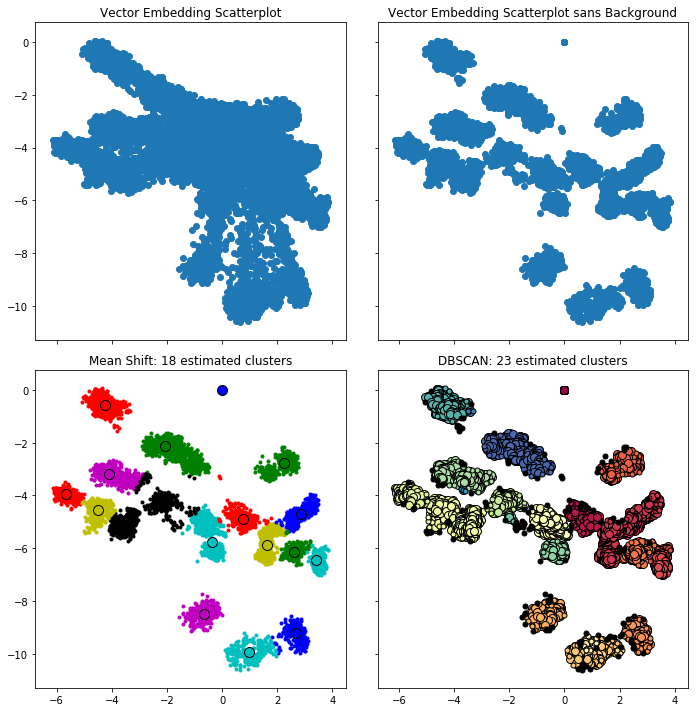

In [10]:
# Scatter plot of the 2D Vectors
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

test_plot = test_images_2d[index, :, :, :].reshape(-1, 2)
ax[0].scatter(x=test_plot[:, 0], y=test_plot[:, 1])
ax[0].set_title('Vector Embedding Scatterplot')

test_plot = test_images_2d_post_fgbg[index, :, :, :].reshape(-1, 2)
ax[1].scatter(x=test_plot[:, 0], y=test_plot[:, 1])
ax[1].set_title('Vector Embedding Scatterplot sans Background')

# Scatter Plot for MeanShift
for k, col in zip(range(np.unique(ms.labels_).size), cycle('bgrcmyk')):
    my_members = ms.labels_ == k
    cluster_center = ms.cluster_centers_[k]
    ax[2].plot(test_plot[my_members, 0], test_plot[my_members, 1], col + '.')
    ax[2].plot(cluster_center[0], cluster_center[1], 'o',
               markerfacecolor=col, markeredgecolor='k', markersize=10)
ax[2].set_title('Mean Shift: %d estimated clusters' % len(np.unique(ms.labels_)))

# Scatter Plot for DBSCAN
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.

    class_member_mask = (db.labels_ == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax[3].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

# Number of clusters in labels, ignoring noise if present.
db_n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
ax[3].set_title('DBSCAN: %d estimated clusters' % db_n_clusters_)

fig.tight_layout()
plt.show()

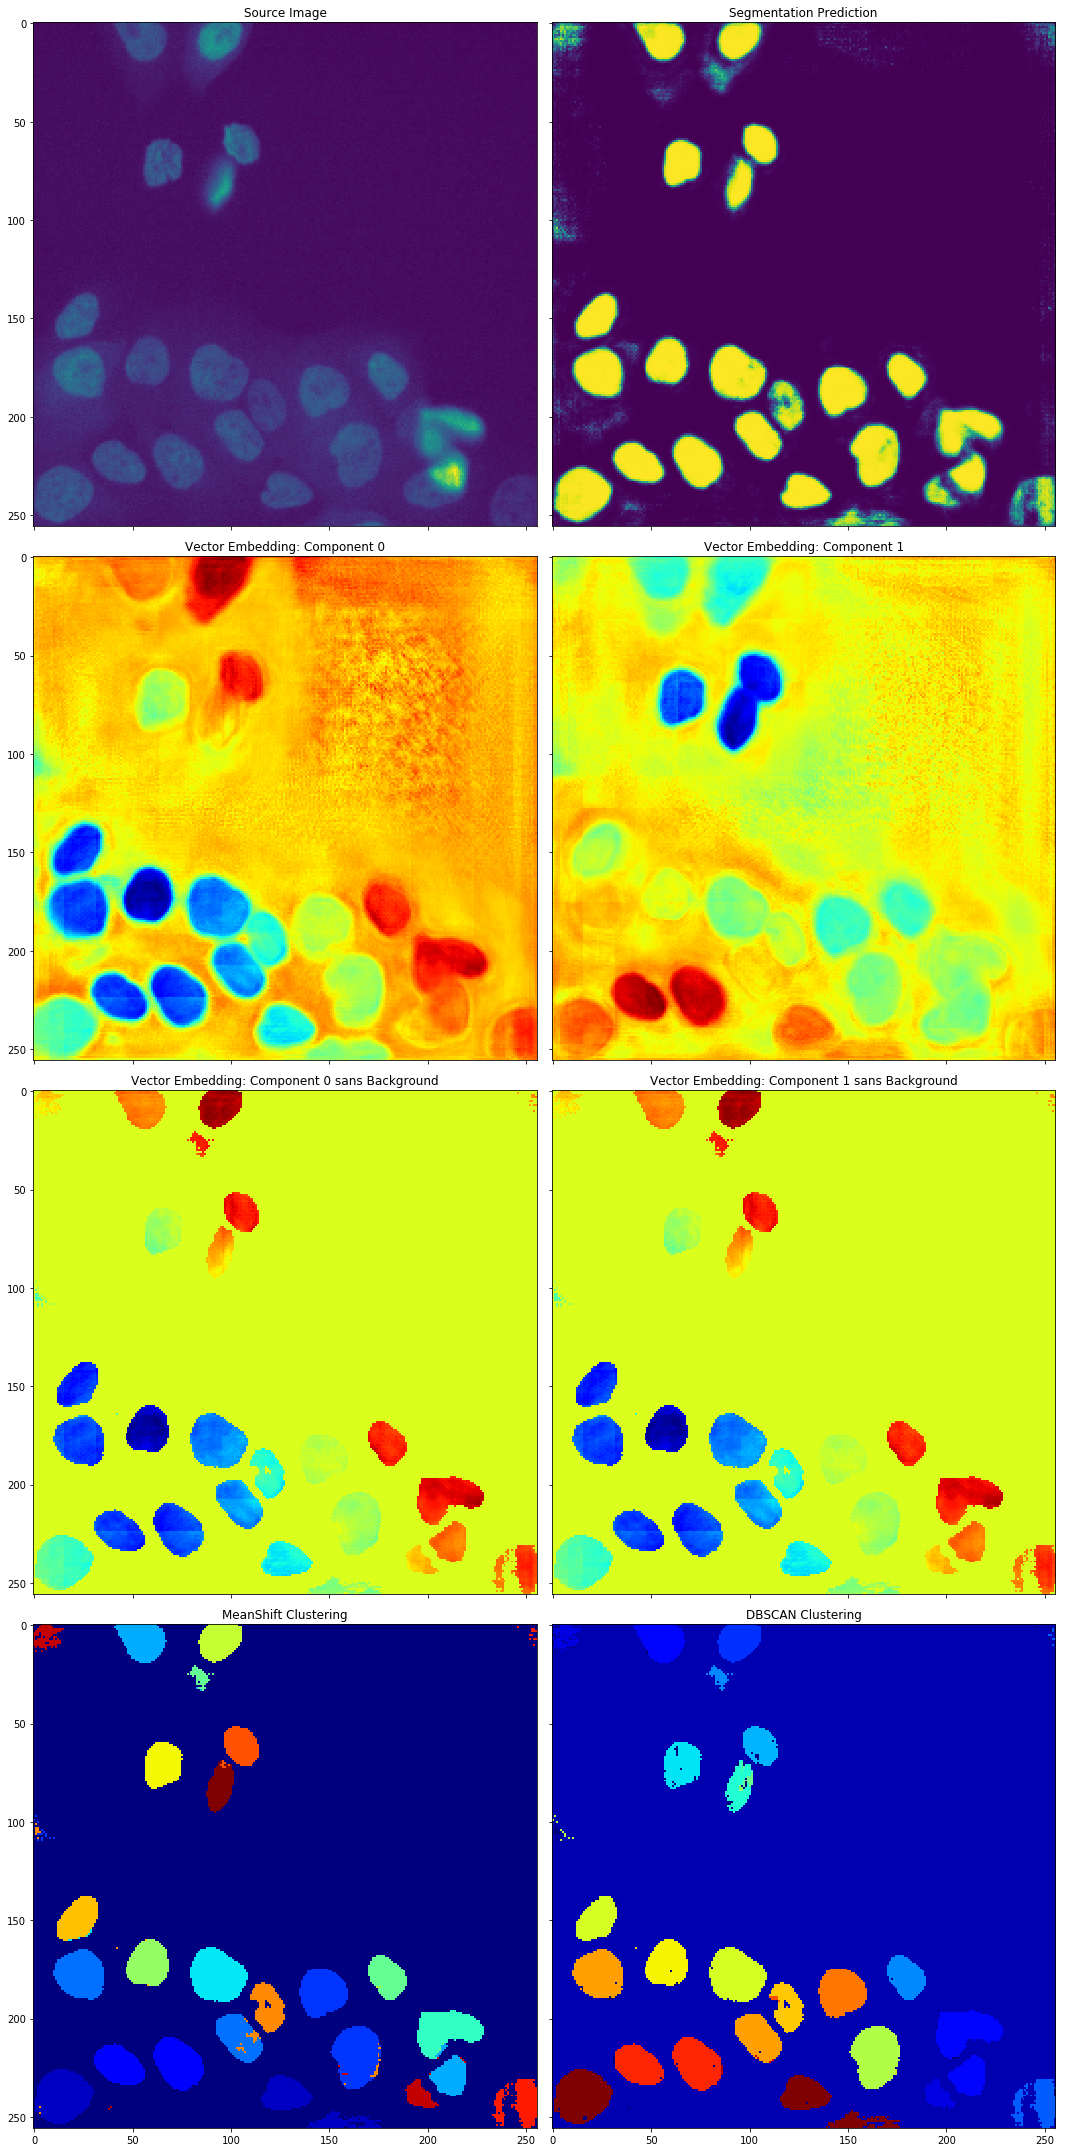

In [11]:
# Plot the results for 2D embedding
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images_2d[index, :, :, 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images_2d[index, :, :, 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_2d_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_2d_post_fgbg[index, :, :, 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

ms = fit_mean_shift(test_images_2d_post_fgbg, index=index, ndim=2, n_samples=500)
ax[6].imshow(ms.labels_.reshape(256, 256), cmap='jet')
ax[6].set_title('MeanShift Clustering')

db = fit_dbscan(test_images_2d_post_fgbg, index=index, ndim=2, eps=0.12)
ax[7].imshow(db.labels_.reshape(256, 256), cmap='jet')
ax[7].set_title('DBSCAN Clustering')

fig.tight_layout()
plt.show()

### 3D Vector Embedding

In [12]:
# Instantiate the model
disc_model_3d = disc_net(
    input_shape=input_shape,
    norm_method='std',
    n_features=3,  # Embedding dimensions
    seg_model=fgbg_model,
    softmax=False)

# Train the model
train_model_disc(
    model=disc_model_3d,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    class_weight=class_weights,
    rotation_range=180,
    zoom_range=[0.8, 1.2],  # a float or a tuple or list of two floats
    flip=True,
    shear=True)

X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Epoch 1/20
201/202 [============================>.] - ETA: 0s - loss: 5.6682
Epoch 00001: val_loss improved from inf to 2.85889, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv__0.h5
202/202 [==============================] - 31s 151ms/step - loss: 5.6698 - val_loss: 2.8589
Epoch 2/20
201/202 [============================>.] - ETA: 0s - loss: 5.4875
Epoch 00002: val_loss improved from 2.85889 to 2.74767, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-08-25_disc_channels_last_conv__0.h5
202/202 [==============================] - 24s 118ms/step - loss: 5.4834 - val_loss: 2.7477
Epoch 3/20
201/202 [============================>.] - ETA: 0s - loss: 5.4677
Epoch 00003: val_loss improved from 2.74767 to 2.71941, saving model to /d

In [13]:
test_images_3d = disc_model_3d.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

# threshold the foreground/background
# and remove background from vector embedding
fg_thresh = test_images_fgbg[:, :, :, 1] > 0.6
fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
test_images_3d_post_fgbg = test_images_3d * fg_thresh

print(test_images_3d.shape)
print(test_images_fgbg.shape)
print(test_images_3d_post_fgbg.shape)

(23, 256, 256, 3)
(23, 256, 256, 3)
(23, 256, 256, 3)


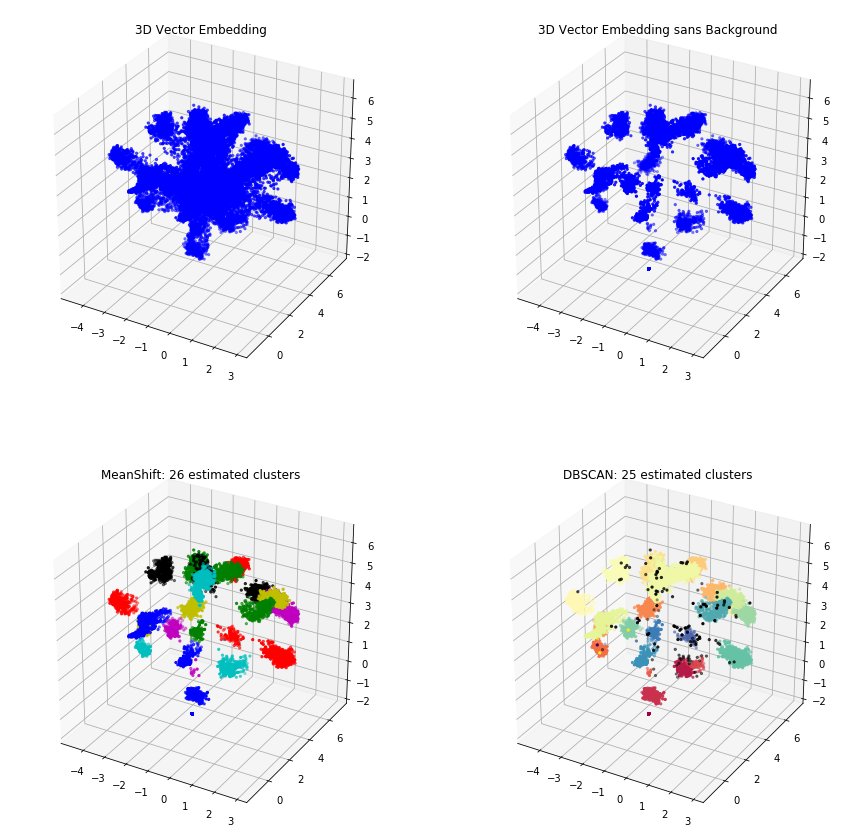

In [14]:
# Scatter plot of the 3D Vectors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

index = 0

fig = plt.figure(figsize=(15, 15))

# 3D Vector Embedding
ax = fig.add_subplot(221, projection='3d')
test_plot = test_images_3d[index, :, :, :].reshape(-1, 3)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding')

# 3D Vector Embedding sans Background
ax = fig.add_subplot(222, projection='3d')
test_plot = test_images_3d_post_fgbg[index, :, :, :].reshape(-1, 3)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding sans Background')

# Scatter plot after MeanShift
ms = fit_mean_shift(test_images_3d_post_fgbg, index=index, ndim=3, n_samples=2000)
n_clusters_ms = np.unique(ms.labels_).size
ax = fig.add_subplot(223, projection='3d')
for k, col in zip(range(n_clusters_ms), cycle('bgrcmyk')):
    my_members = ms.labels_ == k
    ax.scatter(test_plot[my_members, 0],
               test_plot[my_members, 1],
               test_plot[my_members, 2],
               c=col, s=5)
ax.set_title('MeanShift: %d estimated clusters' % n_clusters_ms)

# Scatter plot after DBSCAN
db = fit_dbscan(test_images_3d_post_fgbg, index=index, ndim=3, eps=0.2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_db = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

ax = fig.add_subplot(224, projection='3d')

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Scatter plot after DBScan
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.

    class_member_mask = (db.labels_ == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2],'o', c=col, s=5)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2],'o', c=col, s=5)

ax.set_title('DBSCAN: %d estimated clusters' % n_clusters_db)

plt.show()

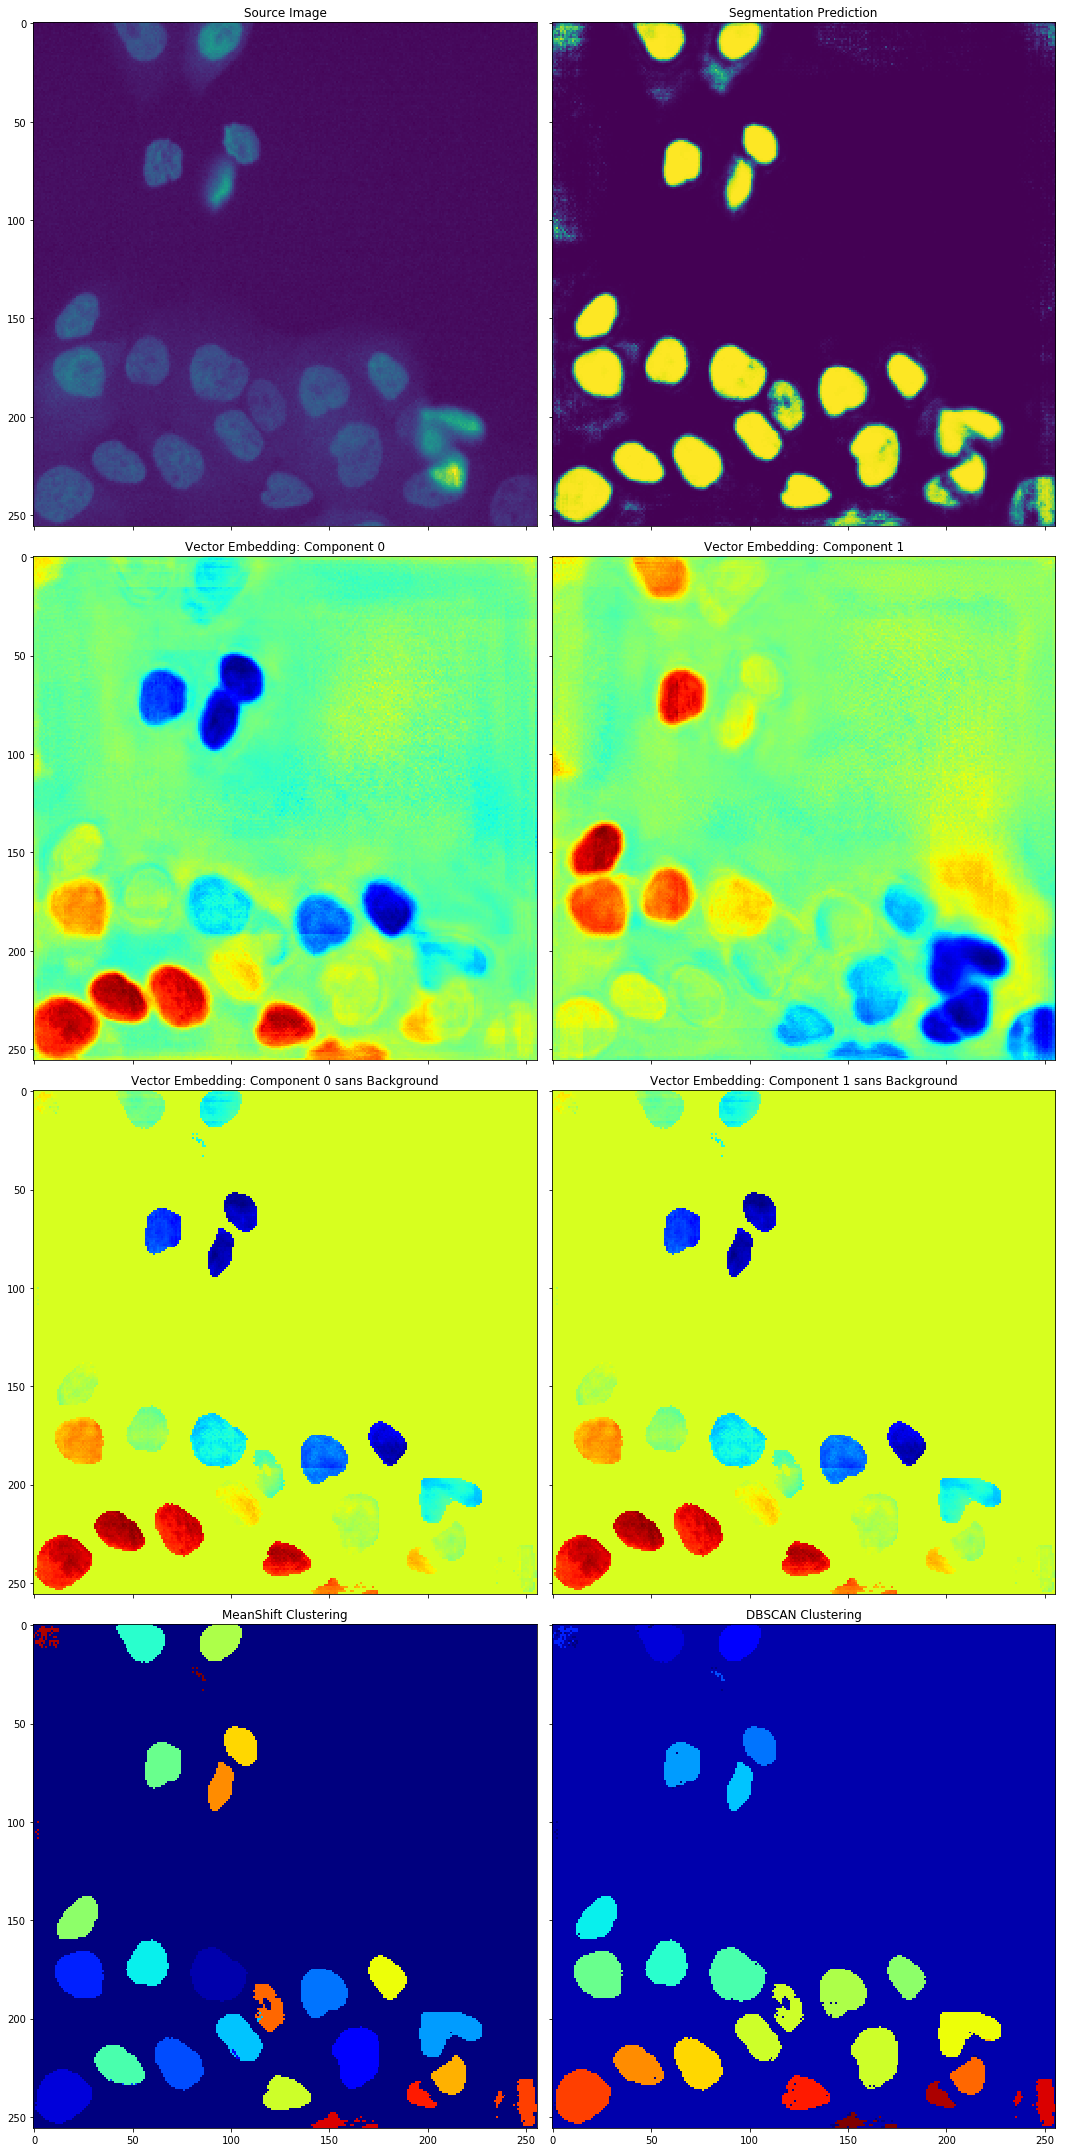

In [15]:
# Plot the results for 2D embedding
import matplotlib.pyplot as plt

index = 0

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images_3d[index, :, :, 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images_3d[index, :, :, 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_3d_post_fgbg[index, :, :, 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_3d_post_fgbg[index, :, :, 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

ms = fit_mean_shift(test_images_3d_post_fgbg, index=index, ndim=3, n_samples=2000)
ax[6].imshow(ms.labels_.reshape(256, 256), cmap='jet')
ax[6].set_title('MeanShift Clustering')

db = fit_dbscan(test_images_3d_post_fgbg, index=index, ndim=3, eps=0.2)
ax[7].imshow(db.labels_.reshape(256, 256), cmap='jet')
ax[7].set_title('DBSCAN Clustering')

fig.tight_layout()
plt.show()